# Maxp Regionalization

**Authors: [Sergio Rey](https://github.com/sjsrey), [Xin Feng](https://github.com/xf37)**    


The `maxp` problem involves the clustering of a set of geographic areas into the maximum number of homogeneous regions such that the value of a spatially extensive regional attribute is above a predefined threshold value.
The spatially extensive attribute can be specified to ensure that each region contains sufficient population size, or a minimum number of enumeration units. The number of regions $p$ is endogenous to the problem and is useful for regionalization problems where the analyst does not require a fixed number of regions a-priori.

Originally formulated as a mixed-integer problem in [Duque, Anselin, Rey (2012)](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1467-9787.2011.00743.x), `maxp` is an [NP-hard problem](https://en.wikipedia.org/wiki/NP-hardness) and exact solutions are only feasible for small problem sizes. As such, a number of heuristic solution approaches have been suggested. PySAL implements the heuristic approach described in
[Wei, Rey, and Knaap (2020)](https://www.tandfonline.com/doi/full/10.1080/13658816.2020.1759806).

In [1]:
%load_ext watermark
%watermark

Last updated: 2021-01-16T13:53:38.839691-08:00

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.18.1

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 5.4.0-59-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 16
Architecture: 64bit



In [2]:
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
import libpysal
import numpy

from spopt import MaxPHeuristic as MaxP

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

## Mexican State Regional Income Clustering

To illustrate `maxp` we utilize data on regional incomes for Mexican states over the period 1940-2000, originally used in [Rey and Sastré-Gutiérrez (2010)](https://www.tandfonline.com/doi/full/10.1080/17421772.2010.493955?casa_token=r6iIZaEKaywAAAAA%3ARxjQkEOcxQ5gffa1EGyd2rByA6w0uVxg5cU3v4VaSmx2u89Nr3oSe2f_n63CV20Ysrjs07U47m98). 

We can first explore the data by plotting the per capital gross regional domestic product (in constant USD 2000 dollars) for each year in the sample, using a quintile classification:

In [4]:
pth = libpysal.examples.get_path('mexicojoin.shp')
mexico = gpd.read_file(pth)


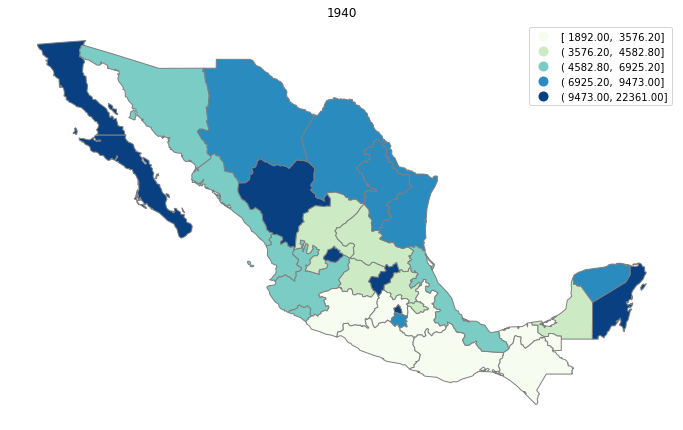

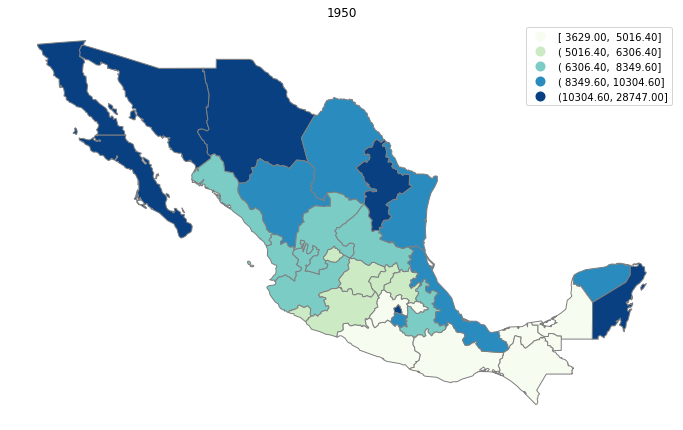

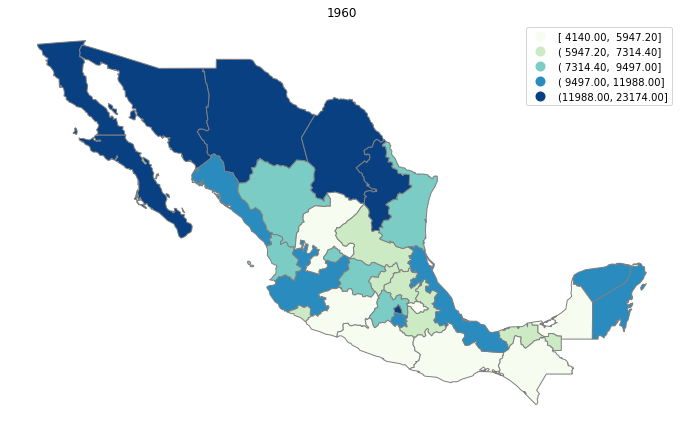

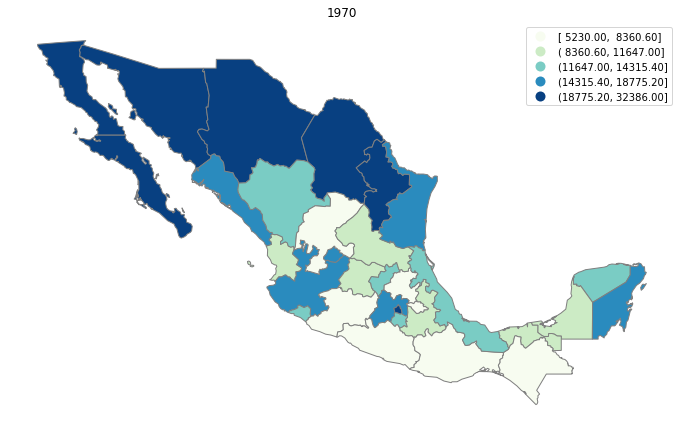

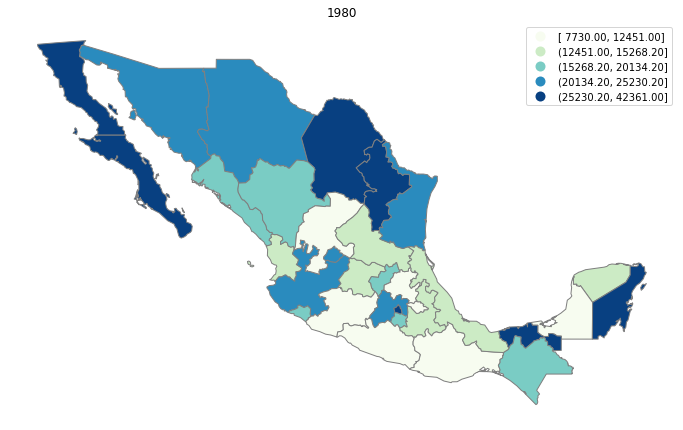

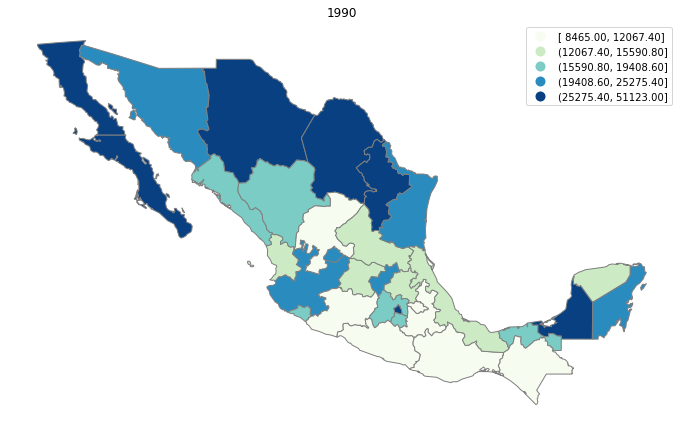

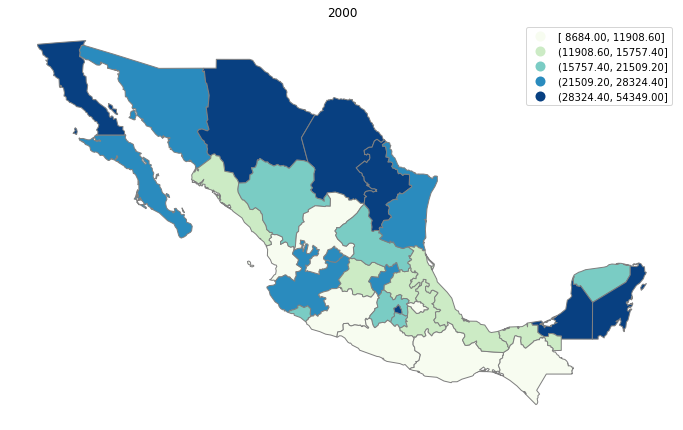

In [5]:
for year in range(1940, 2010, 10):
    ax = mexico.plot(column=f'PCGDP{year}', scheme='Quantiles', cmap='GnBu', edgecolor='grey', legend=True)
    _ = ax.axis('off')
    plt.title(str(year))

In general terms, the north-south divide in incomes is present in each of the 7 decades. There is some variation in states moving across quintiles however, and this is true at both the bottom and top of the state income distribution.

To develop a holistic view of the Mexican space economy over this timespan, we can try to form a set of spatially connected regions that maximizes the internal socieconomic levels of the states belonging to each region.

## Pooled Regionalization

To develop our holistic view, we can treat the six cross-sections as a multidimensional array and seek to 
cluster 32 Mexican states into the maximum number of regions such that each region as at least 6 = 32 // 5 states and homogeneity in per capita gross regional product over 1940-2000 is maximized.

We first define the variables in the dataframe that will be used to measure regional homogeneity:

In [6]:
attrs_name = [f'PCGDP{year}' for year in range(1940,2010, 10)]
attrs_name

['PCGDP1940',
 'PCGDP1950',
 'PCGDP1960',
 'PCGDP1970',
 'PCGDP1980',
 'PCGDP1990',
 'PCGDP2000']

Next, we specify a number of parameters that will serve as input to the `maxp` model.

A [spatial weights object](https://pysal.org/libpysal/tutorial.html) expresses the spatial connectivity of the states:

In [7]:
w = libpysal.weights.Queen.from_dataframe(mexico)

The remaining arguments are the minimum number of states each region must have (`threshold`):

In [8]:
threshold = 6

and the number of the top candidate regions to consider when assigning enclaves (`top_n`):

In [9]:
top_n = 2

We create the attribute `count` which will serve as the threshold attribute which we add to the dataframe:

In [10]:
mexico['count'] = 1
threshold_name = 'count'

The model can then be instantiated and solved:

In [11]:
model = MaxP(mexico, w, attrs_name, threshold_name, threshold, top_n)
model.solve()

In [12]:
mexico['maxp_new'] = model.labels_

In [13]:
mexico[['maxp_new','AREA']].groupby(by='maxp_new').count()

,AREA
maxp_new,
1,6
2,6
3,6
4,7
5,7


In [14]:
model.p

5

<AxesSubplot:>

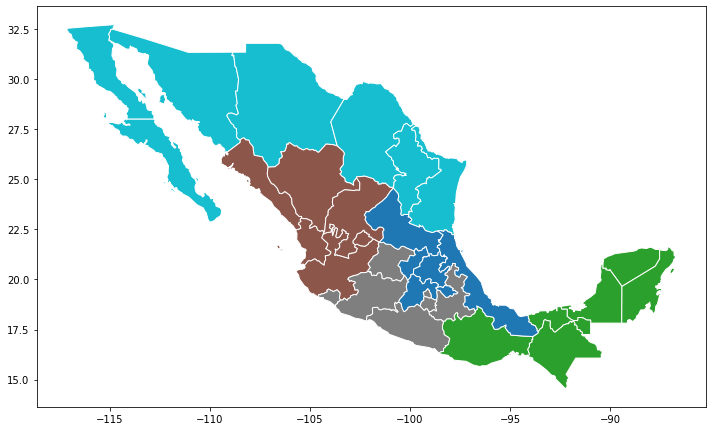

In [15]:
mexico.plot(column='maxp_new', categorical=True,  edgecolor='w')

The model solution results in 5 regions, three of which have 6 states, and three with 7 states each. 
Each region is a [spatially connected component](https://en.wikipedia.org/wiki/Connected_space), as required by the `maxp` problem.


## Change threshold to min of 3 states per region

In [16]:
numpy.random.seed(123456)
threshold=3
model = MaxP(mexico, w, attrs_name, threshold_name, threshold, top_n)
model.solve()

In [17]:
mexico['maxp_3'] = model.labels_
mexico[['maxp_3','AREA']].groupby(by='maxp_3').count()

,AREA
maxp_3,
1,3
2,3
3,4
4,3
5,3
6,3
7,4
8,3
9,3


In [18]:
model.p

10

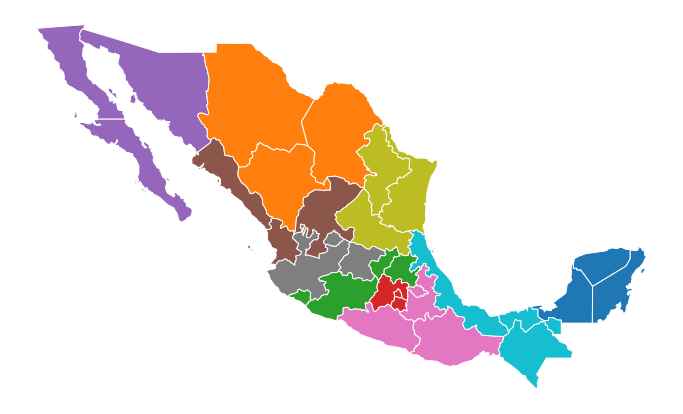

In [19]:
ax = mexico.plot(column='maxp_3', categorical=True, edgecolor='w')
_ = ax.axis('off')

## Year-by-Year Regionalization (Threshold=5 states)

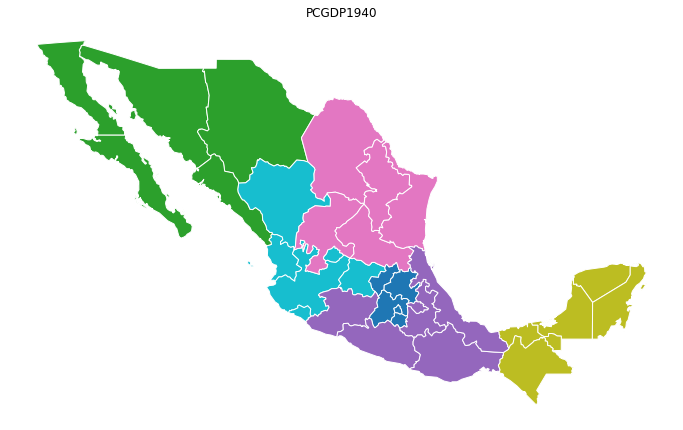

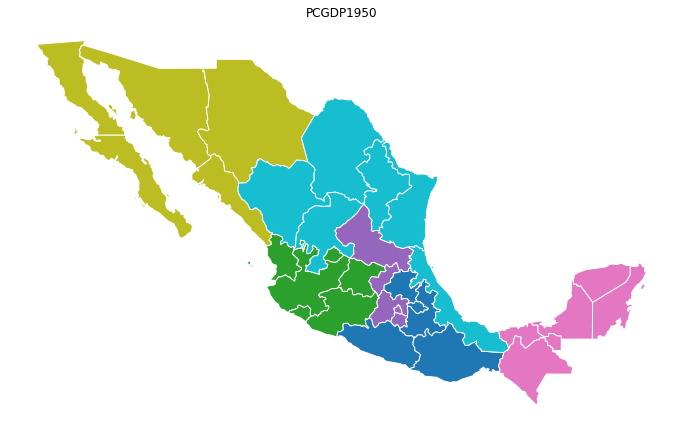

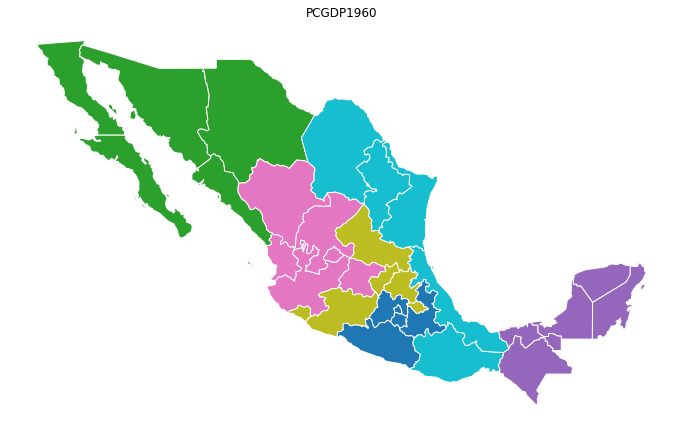

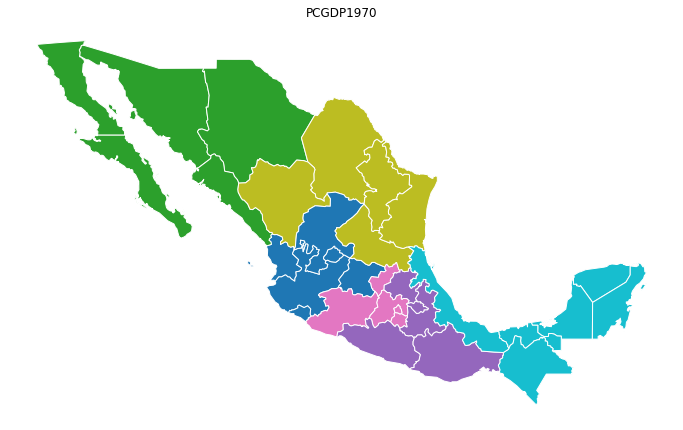

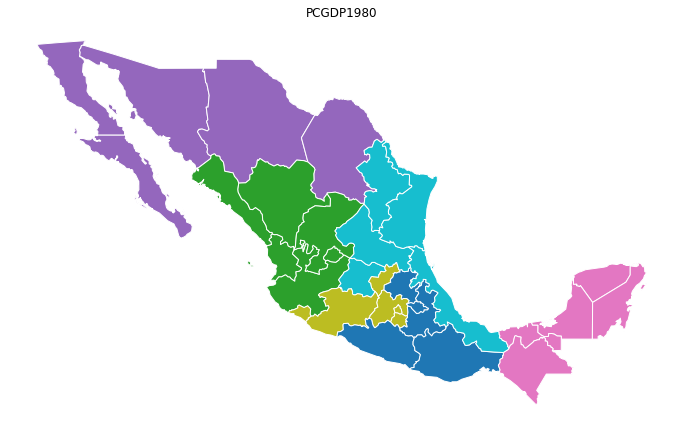

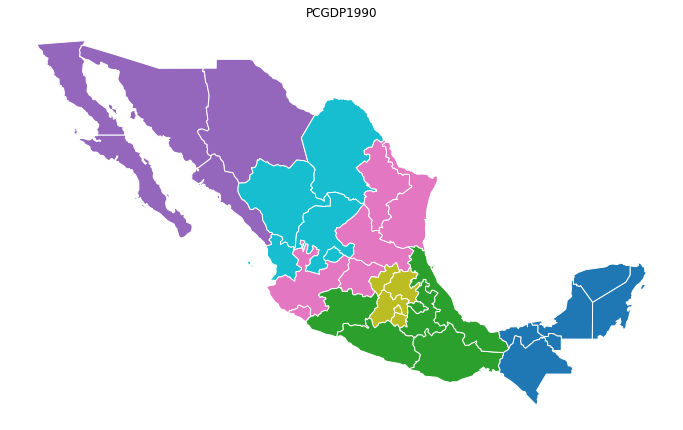

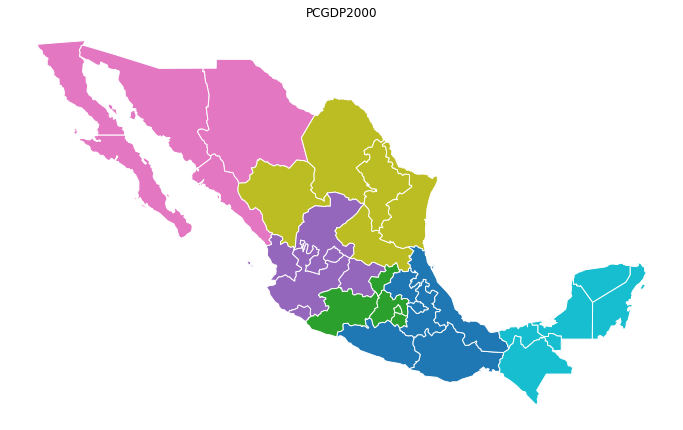

In [20]:
for year in attrs_name:
    
    model = MaxP(mexico, w, year, threshold_name, 5, top_n)
    model.solve()
    lab = year+'labels_'
    mexico[lab] = model.labels_
    ax = mexico.plot(column=lab, categorical=True, edgecolor='w')
    plt.title(year)
    _ = ax.axis('off')
    